# Install & Import

In [1]:
!pip install scikit-learn==1.1.3
!pip install ppca
!pip install klib
!pip install missingpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import klib

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from ppca import PPCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics, tree
from sklearn.cluster import KMeans
from imblearn.under_sampling import ClusterCentroids
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score, auc, roc_auc_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import mode
from imblearn.over_sampling import SMOTENC

import warnings
import sys

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

from missingpy import MissForest

warnings.filterwarnings('ignore')

# Skenario 1: Klasifikasi + SMOTENC + MinMaxScaler

## KODE A: Naive Bayes

In [48]:
# Membaca dataset dari file Excel
dataset = pd.read_excel('dataset_hepatitis.xlsx')

# Mengganti nilai ? dengan Nan
data = dataset.replace('?', np.nan)

# Mnghaus baris missing value
df = data.dropna()
df.to_excel('hasil_dropna.xlsx', index=False)

# Pisahkan atribut (x) dan target (y)
x = df.drop('class', axis=1)
y = df['class']

# Normalisasi dengan Standard Scaler
scaler = MinMaxScaler(feature_range=(0,1))
x_sc = pd.DataFrame(scaler.fit_transform(x.values), columns=x.columns)

# Membuat DataFrame dari hasil Standard Scaler
df_sc = pd.DataFrame(x_sc.values, columns=x_sc.columns)
df_sc['class'] = y
df_sc.to_excel('hasil_scaling.xlsx', index=False)

from imblearn.over_sampling import SMOTENC
# Perform SMOTEN to balance classes
sm = SMOTENC(categorical_features = [1,2,3,4,5,6,7,8,9,10,11,12,18],
             k_neighbors = 5,
             random_state = 0,
             sampling_strategy = 'minority')
x_res, y_res = sm.fit_resample(x_sc.values, y)

# Membuat DataFrame dari hasil SMOTE
df_smote = pd.DataFrame(x_res, columns=x_sc.columns)
df_smote['class'] = y_res
df_smote.to_excel('hasil_smote.xlsx', index=False)

# Import fungsi split data dengan train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, stratify=y_res, test_size=0.3, random_state=0)

# Memanggil fungsi klasifikasi Naive bayes
gnb = GaussianNB()

# Memasukkan data training pada fungsi klasifikasi naive bayes
y_pred = gnb.fit(x_train, y_train).predict(x_test)

# Menampilkan nilai akurasi dari klasifikasi naive bayes
print('Nilai akurasi komposisi 70:30 adalah {:.2f}%'.format(metrics.accuracy_score(y_test, y_pred)*100))

Nilai akurasi komposisi 70:30 adalah 92.68%


### RMSE

In [49]:
from sklearn.metrics import mean_squared_error

# Menghitung RMSE untuk setiap klasifikasi
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Menampilkan nilai RMSE
print('Nilai RMSE komposisi 70:30 adalah {:.2f}'.format(rmse))

Nilai RMSE komposisi 70:30 adalah 0.27


### Confusion Matrix

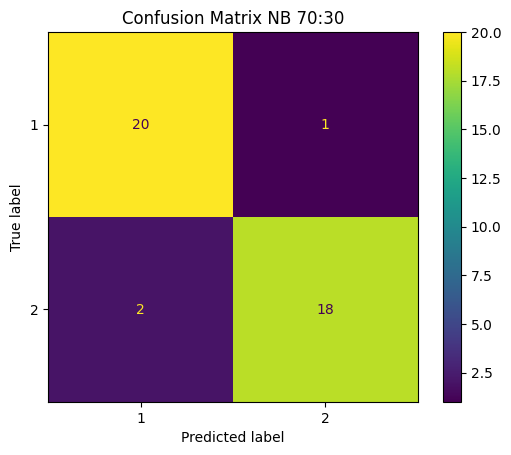

In [50]:
disp = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix
                                        (y_test, y_pred),
                                        display_labels=gnb.classes_)
disp.plot()
plt.title('Confusion Matrix NB 70:30')
plt.show()
print()

### AUCROC

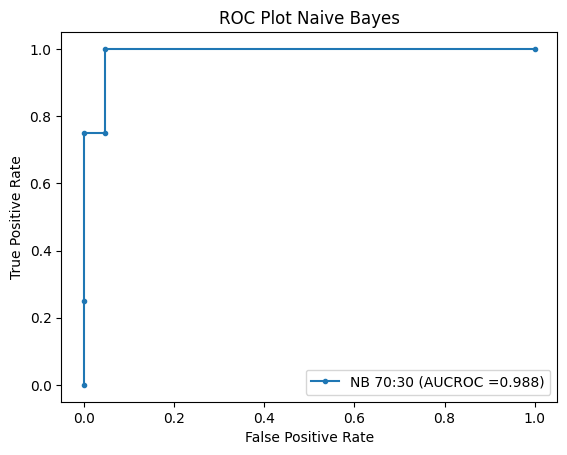

In [51]:
#plot ROC curve dengan matplotlib.pyplot
from sklearn.metrics import auc

y_dec = gnb.fit(x_train, y_train).predict_proba(x_test)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_dec, pos_label=2)

plt.plot(fpr, tpr, marker='.', label="NB 70:30 (AUCROC ={:.3f})".format(auc(fpr, tpr)))

plt.title('ROC Plot Naive Bayes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## KODE B: RandomForest

In [69]:
# Membaca dataset dari file Excel
dataset = pd.read_excel('dataset_hepatitis.xlsx')

# Mengganti nilai ? dengan Nan
data = dataset.replace('?', np.nan)

# Mnghaus baris missing value
df = data.dropna()
df.to_excel('hasil_dropna.xlsx', index=False)

# Pisahkan atribut (x) dan target (y)
x = df.drop('class', axis=1)
y = df['class']

# Normalisasi dengan Standard Scaler
scaler = MinMaxScaler()
# scaler = StandardScaler()
x_sc = pd.DataFrame(scaler.fit_transform(x.values), columns=x.columns)

# Membuat DataFrame dari hasil Standard Scaler
df_sc = pd.DataFrame(x_sc.values, columns=x_sc.columns)
df_sc['class'] = y
df_sc.to_excel('hasil_scaling.xlsx', index=False)

from imblearn.over_sampling import SMOTENC
# Perform SMOTENC to balance classes
sm = SMOTENC(categorical_features = [1,2,3,4,5,6,7,8,9,10,11,12,18],
             k_neighbors = 5,
             random_state = 0,
             sampling_strategy = 'minority')
x_res, y_res = sm.fit_resample(x_sc.values, y)

# Membuat DataFrame dari hasil SMOTE
df_smote = pd.DataFrame(x_res, columns=x_sc.columns)
df_smote['class'] = y_res
df_smote.to_excel('hasil_smote.xlsx', index=False)

# Import fungsi split data dengan train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, stratify=y_res, test_size=0.3, random_state=0)

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0,
                            class_weight='balanced',
                            n_estimators=100)

# Memasukkan data training pada fungsi klasifikasi naive bayes
y_pred = rf.fit(x_train, y_train).predict(x_test)

# Menampilkan nilai akurasi dari klasifikasi naive bayes
print('Nilai akurasi komposisi 70:30 adalah {:.2f}%'.format(metrics.accuracy_score(y_test, y_pred)*100))

Nilai akurasi komposisi 70:30 adalah 92.68%


### RMSE

In [70]:
from sklearn.metrics import mean_squared_error

# Menghitung RMSE untuk setiap klasifikasi
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Menampilkan nilai RMSE
print('Nilai RMSE komposisi 70:30 adalah {:.2f}'.format(rmse))

Nilai RMSE komposisi 70:30 adalah 0.27


### Confusion Matrix

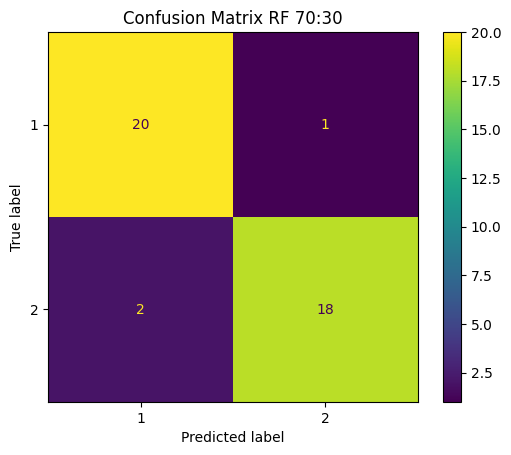

In [71]:
disp = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix
                                        (y_test, y_pred),
                                        display_labels=rf.classes_)
disp.plot()
plt.title('Confusion Matrix RF 70:30')
plt.show()
print()

### AUCROC

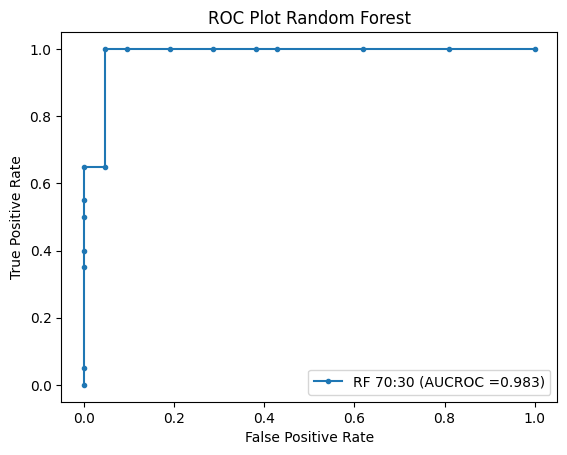

In [72]:
#plot ROC curve dengan matplotlib.pyplot
from sklearn.metrics import auc

y_dec = rf.fit(x_train, y_train).predict_proba(x_test)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_dec, pos_label=2)

plt.plot(fpr, tpr, marker='.', label="RF 70:30 (AUCROC ={:.3f})".format(auc(fpr, tpr)))

plt.title('ROC Plot Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Skenario 2: Klasifikasi + MF + SMOTENC + MinMaxScaler

## Kode A: Naive Bayes

In [82]:
# Load dataset
df = pd.read_excel('dataset_hepatitis.xlsx')

# Split dataset into input and output variables
x = df.drop(['class'], axis=1)
y = df['class']

x = x.replace('?', np.nan)

# fitur kategorikal dinyatakan ke dalam cat_column
cat_column = ['sex','steroid','antivirals','fatigue','malaise','anorexia',
              'liver_big','liver_firm','spleen_palpable','spiders','ascites',
              'varices','histology']
cat_cols = []

for i in cat_column :
    cat_cols.append(x.columns.to_list().index(i))

# Imputasi missforest
imputer = MissForest(max_iter=10, # iterasi maksimal sampai 10
                     n_estimators=100, # jumlah pohon yang akan digunakan
                     class_weight='balanced', # meningkatkan bobot kelas minoritas dan mengurangi bobot kelas mayoritas dalam menghitung prediksi
                     random_state=75) # berfungsi agar proses pelatihan model memperoleh hasil yang sama walaupun dijalankan berulang kali
x_imputed = imputer.fit_transform(x, cat_vars=cat_cols) # cat_vars berfungsi sebagai penentu fitur kategorikal pada dataset

# menyimpan data hasil imputasi ke csv
df_imputed = pd.DataFrame(x_imputed, columns=x.columns)
df_imputed['class'] = y
x_imp = df_imputed.drop(['class'], axis=1)
x_imp.to_excel('hepatitis_missforest.xlsx', index=False)

# Normalisasi dengan Standard Scaler
scaler = MinMaxScaler(feature_range=(0,1))
# scaler = StandardScaler()
x_sc = pd.DataFrame(scaler.fit_transform(x_imp.values), columns=x_imp.columns)

# Membuat DataFrame dari hasil Standard Scaler
df_sc = pd.DataFrame(x_sc, columns=x_sc.columns)
df_sc['class'] = y
df_sc.to_excel('hasil_scaling.xlsx', index=False)

from imblearn.over_sampling import SMOTENC
# Perform SMOTEN to balance classes
sm = SMOTENC(categorical_features = [1,2,3,4,5,6,7,8,9,10,11,12,18],
             k_neighbors = 5,
             random_state = 0,
             sampling_strategy = 'minority')
x_res, y_res = sm.fit_resample(x_sc.values, y)

# Membuat DataFrame dari hasil SMOTE
df_smote = pd.DataFrame(x_res, columns=x_sc.columns)
df_smote['class'] = y_res
df_smote.to_excel('hasil_smote.xlsx', index=False)

# Import fungsi split data dengan train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, stratify=y_res, test_size=0.3, random_state=0)

# Memanggil fungsi klasifikasi Naive bayes
gnb = GaussianNB()

# Memasukkan data training pada fungsi klasifikasi naive bayes
y_pred = gnb.fit(x_train, y_train).predict(x_test)

# Menampilkan nilai akurasi dari klasifikasi naive bayes
print()
print('Nilai akurasi komposisi 70:30 adalah {:.2f}%'.format(metrics.accuracy_score(y_test, y_pred)*100))

Iteration: 0
Iteration: 1
Iteration: 2

Nilai akurasi komposisi 70:30 adalah 100.00%


In [76]:
df_imputed

,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology,class
0,30.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,85.00,18.0,4.0,86.44,1.0,2
1,50.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,0.9,135.00,42.0,3.5,54.14,1.0,2
2,78.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.7,96.00,32.0,4.0,75.61,1.0,2
3,31.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.7,46.00,52.0,4.0,80.00,1.0,2
4,34.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,74.24,200.0,4.0,70.21,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,46.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,7.6,131.75,242.0,3.3,50.00,2.0,1
151,44.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,0.9,126.00,142.0,4.3,66.29,2.0,2
152,61.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,0.8,75.00,20.0,4.1,79.78,2.0,2
153,53.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,1.5,81.00,19.0,4.1,48.00,2.0,2


In [77]:
df_sc

,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology,class
0,0.323944,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.090909,0.219331,0.006309,0.441860,0.8644,0.0,2
1,0.605634,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.077922,0.405204,0.044164,0.325581,0.5414,0.0,2
2,1.000000,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.051948,0.260223,0.028391,0.441860,0.7561,0.0,2
3,0.338028,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.051948,0.074349,0.059937,0.441860,0.8000,0.0,2
4,0.380282,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.090909,0.179331,0.293375,0.441860,0.7021,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,0.549296,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.948052,0.393123,0.359621,0.279070,0.5000,1.0,1
151,0.521127,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.077922,0.371747,0.201893,0.511628,0.6629,1.0,2
152,0.760563,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.064935,0.182156,0.009464,0.465116,0.7978,1.0,2
153,0.647887,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.155844,0.204461,0.007886,0.465116,0.4800,1.0,2


In [78]:
df_smote

,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology,class
0,0.323944,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.090909,0.219331,0.006309,0.441860,0.864400,0.0,2
1,0.605634,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.077922,0.405204,0.044164,0.325581,0.541400,0.0,2
2,1.000000,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.051948,0.260223,0.028391,0.441860,0.756100,0.0,2
3,0.338028,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.051948,0.074349,0.059937,0.441860,0.800000,0.0,2
4,0.380282,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.090909,0.179331,0.293375,0.441860,0.702100,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,0.519155,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.083376,0.386992,0.056721,0.262359,0.411400,1.0,1
242,0.440831,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.116020,0.347936,0.003888,0.161245,0.406194,1.0,1
243,0.525299,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.079818,0.404900,0.065379,0.267785,0.410155,1.0,1
244,0.644125,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.147705,0.249860,0.139553,0.334263,0.361199,1.0,1


### RMSE

In [79]:
from sklearn.metrics import mean_squared_error

# Menghitung RMSE untuk setiap klasifikasi
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Menampilkan nilai RMSE
print('Nilai RMSE komposisi 70:30 adalah {:.2f}'.format(rmse))

Nilai RMSE komposisi 70:30 adalah 0.00


### Confusion Matrix

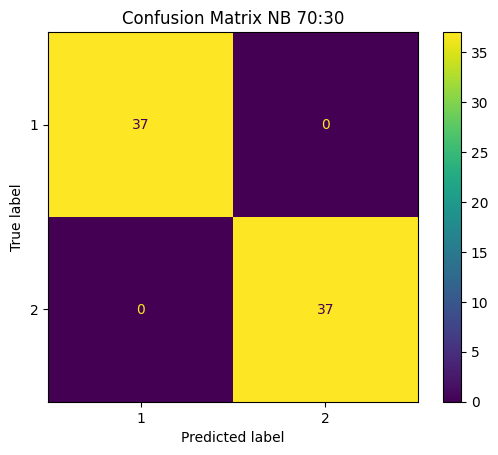

In [80]:
disp = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix
                                        (y_test, y_pred),
                                        display_labels=gnb.classes_)
disp.plot()
plt.title('Confusion Matrix NB 70:30')
plt.show()
print()

### AUCROC

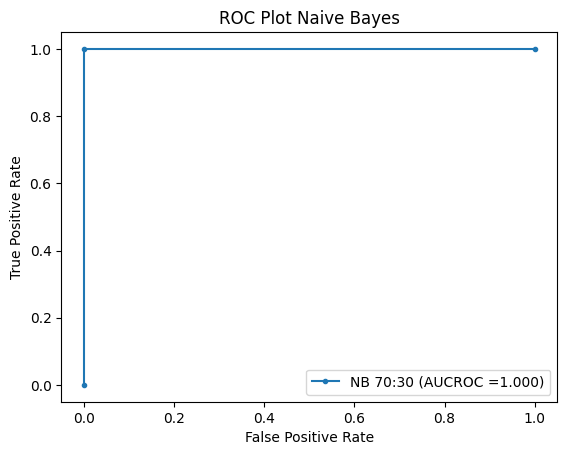

In [83]:
#plot ROC curve dengan matplotlib.pyplot
from sklearn.metrics import auc

y_dec = gnb.fit(x_train, y_train).predict_proba(x_test)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_dec, pos_label=2)

plt.plot(fpr, tpr, marker='.', label="NB 70:30 (AUCROC ={:.3f})".format(auc(fpr, tpr)))

plt.title('ROC Plot Naive Bayes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Kode B: RandomForest

In [97]:
# Load dataset
df = pd.read_excel('dataset_hepatitis.xlsx')

# Split dataset into input and output variables
x = df.drop(['class'], axis=1)
y = df['class']

x = x.replace('?', np.nan)

# fitur kategorikal dinyatakan ke dalam cat_column
cat_column = ['sex','steroid','antivirals','fatigue','malaise','anorexia',
              'liver_big','liver_firm','spleen_palpable','spiders','ascites',
              'varices','histology']
cat_cols = []

for i in cat_column :
    cat_cols.append(x.columns.to_list().index(i))

# Imputasi missforest
imputer = MissForest(max_iter=10, # iterasi maksimal sampai 10
                     n_estimators=100, # jumlah pohon yang akan digunakan
                     class_weight='balanced', # meningkatkan bobot kelas minoritas dan mengurangi bobot kelas mayoritas dalam menghitung prediksi
                     random_state=75) # berfungsi agar proses pelatihan model memperoleh hasil yang sama walaupun dijalankan berulang kali
x_imputed = imputer.fit_transform(x, cat_vars=cat_cols) # cat_vars berfungsi sebagai penentu fitur kategorikal pada dataset

# menyimpan data hasil imputasi ke csv
df_imputed = pd.DataFrame(x_imputed, columns=x.columns)
df_imputed['class'] = y
x_imp = df_imputed.drop(['class'], axis=1)
x_imp.to_excel('hepatitis_missforest.xlsx', index=False)

# Normalisasi dengan Standard Scaler
scaler = MinMaxScaler(feature_range=(0,1))
x_sc = pd.DataFrame(scaler.fit_transform(x_imp.values), columns=x_imp.columns)

# Membuat DataFrame dari hasil Standard Scaler
df_sc = pd.DataFrame(x_sc, columns=x_sc.columns)
df_sc['class'] = y
df_sc.to_excel('hasil_scaling.xlsx', index=False)

from imblearn.over_sampling import SMOTENC
# Perform SMOTEN to balance classes
sm = SMOTENC(categorical_features = [1,2,3,4,5,6,7,8,9,10,11,12,18],
             k_neighbors = 5,
             random_state = 0,
             sampling_strategy = 'minority')
x_res, y_res = sm.fit_resample(x_sc.values, y)

# Membuat DataFrame dari hasil SMOTE
df_smote = pd.DataFrame(x_res, columns=x_sc.columns)
df_smote['class'] = y_res
df_smote.to_excel('hasil_smote.xlsx', index=False)

# Import fungsi split data dengan train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, stratify=y_res, test_size=0.3, random_state=0)

rf = RandomForestClassifier(random_state=0,
                            class_weight='balanced',
                            n_estimators=100)

# Memasukkan data training pada fungsi klasifikasi naive bayes
y_pred = rf.fit(x_train, y_train).predict(x_test)

# Menampilkan nilai akurasi dari klasifikasi naive bayes
print()
print('Nilai akurasi komposisi 70:30 adalah {:.2f}%'.format(metrics.accuracy_score(y_test, y_pred)*100))

Iteration: 0
Iteration: 1
Iteration: 2

Nilai akurasi komposisi 70:30 adalah 100.00%


### RMSE

In [85]:
from sklearn.metrics import mean_squared_error

# Menghitung RMSE untuk setiap klasifikasi
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Menampilkan nilai RMSE
print('Nilai RMSE komposisi 70:30 adalah {:.2f}'.format(rmse))

Nilai RMSE komposisi 70:30 adalah 0.00


### Confusion Matrix

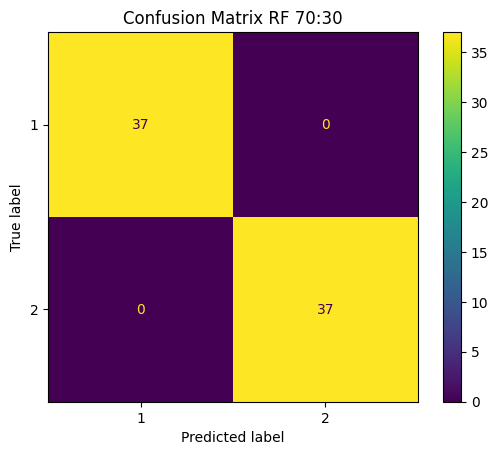

In [86]:
disp = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix
                                        (y_test, y_pred),
                                        display_labels=rf.classes_)
disp.plot()
plt.title('Confusion Matrix RF 70:30')
plt.show()
print()

### AUCROC

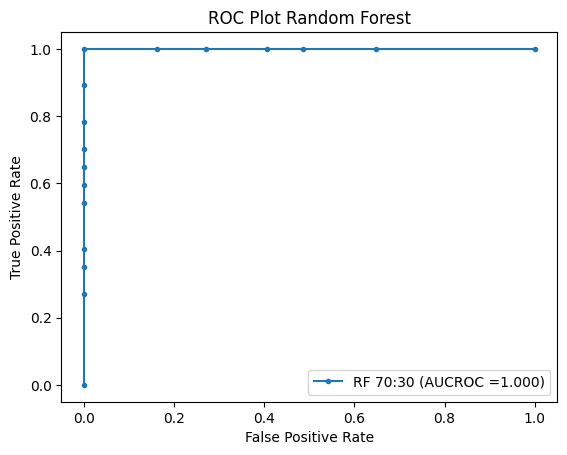

In [87]:
#plot ROC curve dengan matplotlib.pyplot
from sklearn.metrics import auc

y_dec = rf.fit(x_train, y_train).predict_proba(x_test)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_dec, pos_label=2)

plt.plot(fpr, tpr, marker='.', label="RF 70:30 (AUCROC ={:.3f})".format(auc(fpr, tpr)))

plt.title('ROC Plot Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()